In [1]:
# Import packages
library(tidyverse)
library(bnlearn)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘bnlearn’ was built under R version 4.1.3”


# Introduction

Having decided on the nodes to include in the GBN, in this notebook with an R kernel we re-fit the GBN using the training data developed in the previous notebook. This training data has not had NaN filling, unlike the data used in BN development (because of the requirement for no missing values when doing cross validation). Fitted GBN coefficients in this notebook are therefore slightly different to the coefficients in the BN development notebook. Coefficients in this notebook are taken as being more correct, and are the ones used for reporting.

The fitted BN object is saved for use when making predictions.

# File paths

In [2]:
met_source <- "metno"  # choose from 'metno', 'era5' or 'nomet' (the last for a BN with no met nodes)

# End year of desired training data (check BayesianNetwork/Data/BN_TrainingData folder for available date ranges)
# Or set to all the same year if you want to compare like with like
end_yr_li <- list(metno = 2018,
                  era5 = 2018,
                  nomet = 2020)

# File path to training data matrix
training_data_fpath <- sprintf("../Data/BN_TrainingData/TrainingData_GaussianBN_%s_1981-%s.csv",
                               met_source, end_yr_li[[met_source]])

# File path to save bn.fit object to (to be used in making predictions)
rfile_fpath <- sprintf("../Data/RData/Vansjo_fitted_GaussianBN_%s_1981-%s.rds",
                       met_source, end_yr_li[[met_source]])

# Folder to save output diagnostics for the fitted network in
out_folder <- "../Data/FittedNetworkDiagnostics"
# Filepath to fitted standard deviations
out_sd_fpath <- file.path(out_folder, sprintf("GBN_%s_1981-%s_stdevs.csv", met_source, end_yr_li[[met_source]]))

# Create and fit the GBN

In [3]:
# Create the network structure manually

# Create an empty DAG with the desired nodes, no met nodes
if (met_source == "nomet") {
  nodes <- c("TP",
             "TP_prevSummer",
             "chla",
             "chla_prevSummer",
             "cyano",
             "colour_prevSummer",
             "colour")
  dag <- empty.graph(nodes)

  # Manually define the arcs connecting nodes
  arcs_matrix <- matrix(c("TP_prevSummer", "TP",
                          "TP", "chla",
                          "chla_prevSummer", "chla",
                          "chla", "cyano",
                          "colour", "cyano",
                          "colour_prevSummer", "colour",
                          "TP_prevSummer", "chla_prevSummer"),
                        ncol = 2, byrow = TRUE, dimnames = list(NULL, c("from", "to")))

# Create an empty DAG, including met nodes
} else {
    nodes <- c("TP",
                 "TP_prevSummer",
                 "chla",
                 "chla_prevSummer",
                 "wind_speed",
                 "cyano",
                 "colour_prevSummer",
                 "colour",
                 "rain")

  dag <- empty.graph(nodes)

  # Manually define the arcs connecting nodes
  arcs_matrix <- matrix(c("TP_prevSummer", "TP",
                          "TP", "chla",
                          "chla_prevSummer", "chla",
                          "wind_speed", "chla",
                          "chla", "cyano",
                          "colour", "cyano",
                          "colour_prevSummer", "colour",
                          "rain", "colour",
                          "TP_prevSummer", "chla_prevSummer"),
                          ncol = 2, byrow = TRUE, dimnames = list(NULL, c("from", "to")))
}

# Assign the structure to the empty graph using arcs, which turns it into a bnlearn object
arcs(dag) <- arcs_matrix
dag


  Random/Generated Bayesian network

  model:
   [TP_prevSummer][wind_speed][colour_prevSummer][rain][TP|TP_prevSummer]
   [chla_prevSummer|TP_prevSummer][colour|colour_prevSummer:rain]
   [chla|TP:chla_prevSummer:wind_speed][cyano|chla:colour]
  nodes:                                 9 
  arcs:                                  9 
    undirected arcs:                     0 
    directed arcs:                       9 
  average markov blanket size:           3.11 
  average neighbourhood size:            2.00 
  average branching factor:              1.00 

  generation algorithm:                  Empty 


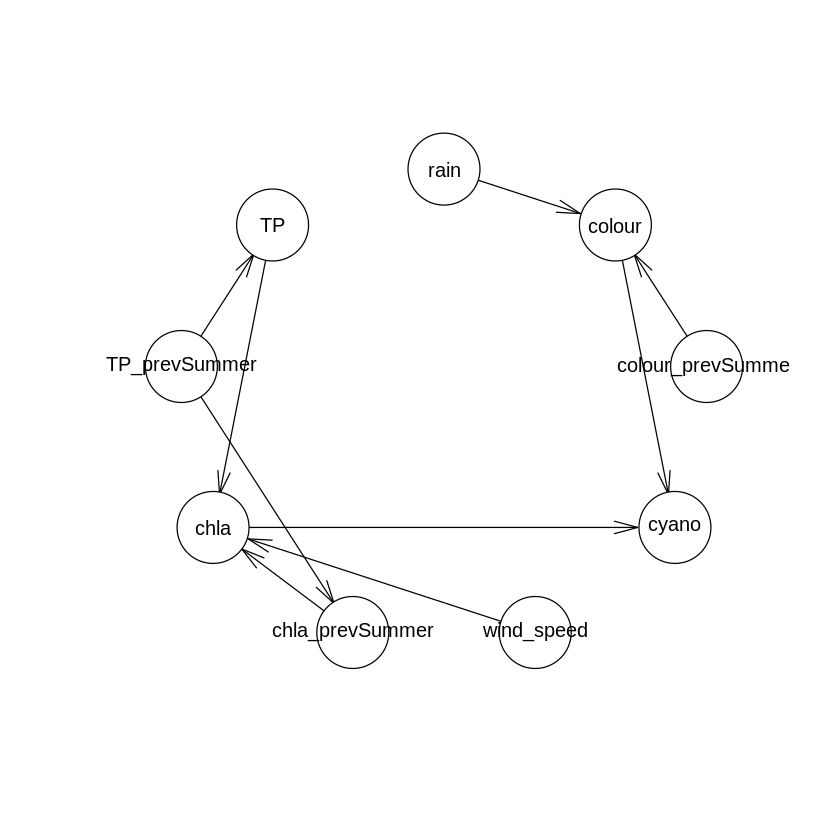

In [4]:
plot(dag)

In [5]:
# Read in historic data which will be used to fit the network params
data_cont <- read.csv(file = training_data_fpath, header = TRUE, sep = ",", row.names = 1)
data_cont[1:ncol(data_cont)] <- lapply(data_cont[1:ncol(data_cont)], as.numeric)  # Convert any integer cols to numeric
data_cont <- data_cont[, (names(data_cont) %in% nodes)]  # Remove any columns that aren't present in the network nodes

# Quick look
head(data_cont)

,rain,colour,TP,chla,wind_speed,cyano,colour_prevSummer,TP_prevSummer,chla_prevSummer
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1981,494.5203,NA,28.83333,8.33125,3.479891,NA,NA,43.57302,16.08013
1982,460.2221,26.66667,26.98810,5.97500,3.790761,NA,NA,28.83333,8.33125
1983,465.4715,17.62500,29.78125,6.05000,4.259239,NA,26.66667,26.98810,5.97500
1984,561.6575,NA,26.52750,11.09000,3.811413,NA,17.62500,29.78125,6.05000
1985,548.1064,34.40476,30.95714,11.89524,3.633152,NA,NA,26.52750,11.09000
1986,428.0660,27.47222,33.78889,12.67778,4.137500,NA,34.40476,30.95714,11.89524


In [6]:
# Fit. Returns a bn.fit object, which includes fitted conditional probability tables for each node
fitted_BN <- bn.fit(dag, data_cont)

# Quick look at the fitted coefficients associated with each node
coefficients(fitted_BN)

$TP
  (Intercept) TP_prevSummer 
   10.8906157     0.6061798 

$TP_prevSummer
(Intercept) 
   29.51101 

$chla
    (Intercept)              TP chla_prevSummer      wind_speed 
     14.8211112       0.4712295       0.3309154      -5.0946506 

$chla_prevSummer
  (Intercept) TP_prevSummer 
   -2.6061590     0.6176962 

$wind_speed
(Intercept) 
   3.569908 

$cyano
(Intercept)        chla      colour 
-1.78977349  0.16870336 -0.02436988 

$colour_prevSummer
(Intercept) 
   41.16852 

$colour
      (Intercept) colour_prevSummer              rain 
      -7.65314625        0.81361028        0.02818543 

$rain
(Intercept) 
    514.667

In [7]:
# Save bn.fit object to file for reading later & using to make predictions
saveRDS(fitted_BN, file = rfile_fpath)

# Calculate/save auxiliary info associated with the network

## Standard deviations

It would also be excellent to save the fitted coefficients in a nice format. This must be easy to do, but I'm so unfamiliar with R that I haven't worked it out.

In [8]:
# Standard deviation of the residuals

# First, make an empty list and then populate it with the standard deviations
sd_li <- vector(mode = "list", length = 0)
for (node in nodes(dag)) {
  sd <- fitted_BN[[node]]$sd
  sd_li[[node]] <- sd
}

# Then turn into a dataframe & save to csv to accompany predictions
sd_df <- data.frame(node = nodes(dag), sd = unlist(sd_li, use.names = FALSE))
write.csv(sd_df, out_sd_fpath, row.names = FALSE)

sd_df

node,sd
<chr>,<dbl>
TP,3.8215308
TP_prevSummer,5.1562681
chla,3.7313117
chla_prevSummer,4.6654852
wind_speed,0.2510378
cyano,0.7356780
colour_prevSummer,17.2582257
colour,8.9102906
rain,102.9717481


## Confidence intervals for the fitted GBN coefficients

Many thanks to M. Scutari for providing this code for calculating confidence intervals.
Again, it would be great to write this out in a nice format to csv, but I haven't figured out how to do that yet.

In [9]:
lapply(as.lm(fitted_BN, data_cont), confint)

,2.5 %,97.5 %
(Intercept),3.3577605,18.4234710
TP_prevSummer,0.3540429,0.8583167
,2.5 %,97.5 %
(Intercept),27.79182,31.23019
,2.5 %,97.5 %
(Intercept),-9.8810872,39.5233097
TP,0.1741786,0.7682804
chla_prevSummer,0.0304969,0.6313338
wind_speed,-11.0325350,0.8432339
,2.5 %,97.5 %
